In [1]:
pip install nltk PyPDF2 py-readability-metrics wordcloud matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#imports

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# PDF
from PyPDF2 import PdfReader

# NLTK / VADER
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

# Download the required NLTK resources (run this once)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Readability
from readability import Readability

# Wordcloud
from wordcloud import WordCloud

# one-time NLTK downloads (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

# Paths to your PDFs
p_fox = Path("foxnews.com-Embattled Harvard University President Claudine Gay hit with more plagiarism charges.pdf")
p_reu = Path("reuters.com-Harvard president will submit dissertation edits after plagiarism allegations.pdf")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-d

In [ ]:
#Extract

In [3]:
def pdf_to_text(pdf_path: Path) -> str:
    reader = PdfReader(str(pdf_path))
    pages = []
    for page in reader.pages:
        try:
            pages.append(page.extract_text() or "")
        except Exception:
            pages.append("")
    text = "\n".join(pages)

    # light cleaning: normalize hyphenation + spacing
    text = re.sub(r"-\n", "", text)          # join hyphenated line-breaks
    text = re.sub(r"\n+", "\n", text)        # squash extra newlines
    text = re.sub(r"[ \t]+", " ", text)      # collapse runs of spaces
    text = text.strip()
    return text

txt_fox = pdf_to_text(p_fox)
txt_reu = pdf_to_text(p_reu)

print("FOX characters:", len(txt_fox))
print("REUTERS characters:", len(txt_reu))


FOX characters: 5321
REUTERS characters: 3618


In [4]:
print(txt_fox[:1200])
print("-"*80)
print(txt_reu[:1200])


1 / 5Brian FloodEmbattled Harvard University President Claudine Gay hit
with more plagiarism charges
foxnews.com /media/embattled-harvard-university-president-claudine-gay-hit-more-plagiarism-charges
Media
Harvard ‘received a complaint outlining over 40 allegations of
plagiarism,’ according to the Free Beacon
 By Brian Flood Fox News
Published December 20, 2023 12:59pm EST
Harvard president facing 40 new allegations of plagiarism
Fox News' Molly Line reports the latest on the allegations. 
Embattled Harvard University President Claudine Gay has been slapped with additional
charges of plagiarism. 
The Washington Free Beacon reported Harvard "received a complaint outlining over 40
allegations of plagiarism" against Gay on T uesday , noting a letter was sent to Harvard's
research integrity of ficer, Stacey Springs, outlining the claims. 
"The document paints a picture of a pattern of misconduct more extensive than has been
previously reported and puts the Harvard Corporation, the universi

In [ ]:
#Sentiment (VADER) for each full article

In [5]:
sia = SentimentIntensityAnalyzer()

def vader_scores(text: str) -> dict:
    return sia.polarity_scores(text)

fox_sent = vader_scores(txt_fox)
reu_sent = vader_scores(txt_reu)

pd.DataFrame([fox_sent, reu_sent], index=["Fox News", "Reuters"])


,neg,neu,pos,compound
Fox News,0.064,0.863,0.073,0.8346
Reuters,0.070,0.904,0.026,-0.9719


In [ ]:
#Headline sentiment

In [6]:
headline_fox = "Embattled Harvard University President Claudine Gay hit with more plagiarism charges"  # from PDF title/article
headline_reu = "Harvard president will submit dissertation edits after plagiarism allegations"          # from PDF title/article

pd.DataFrame(
    [vader_scores(headline_fox), vader_scores(headline_reu)],
    index=["Fox News (headline)", "Reuters (headline)"]
)


,neg,neu,pos,compound
Fox News (headline),0.192,0.808,0.0,-0.3353
Reuters (headline),0.000,1.000,0.0,0.0000


In [ ]:
def readability_report(text: str) -> dict:
    r = Readability(text)
    out = {}
    # Choose a few: Flesch-Kincaid grade, Gunning Fog, SMOG, Coleman-Liau, Dale-Chall, etc.
    out["flesch_kincaid_grade"] = r.flesch_kincaid().grade_level
    out["gunning_fog"]          = r.gunning_fog().score
    out["smog"]                 = r.smog().score
    return out

fox_read = readability_report(txt_fox)
reu_read = readability_report(txt_reu)

pd.DataFrame([fox_read, reu_read], index=["Fox News", "Reuters"])


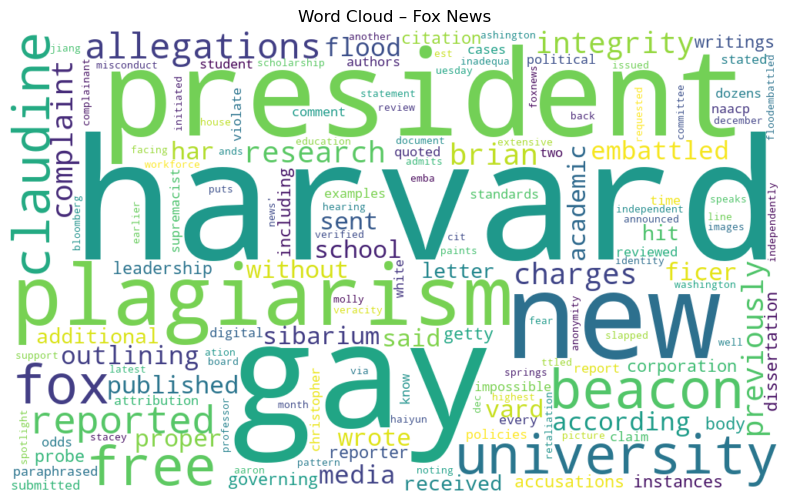

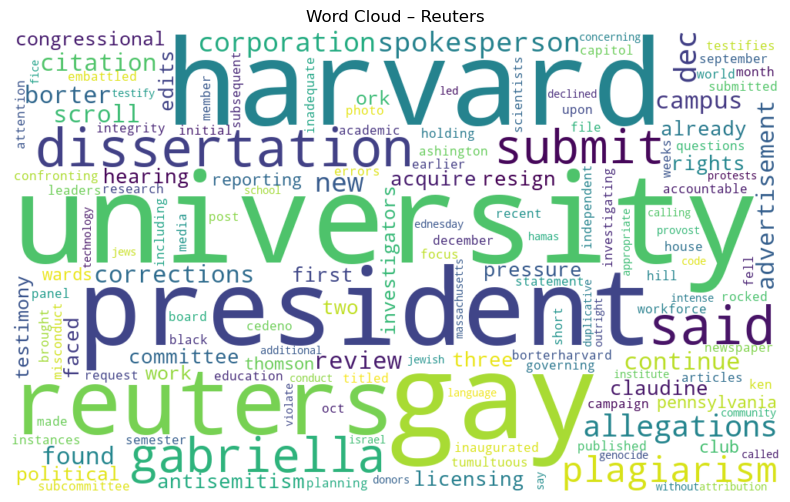

In [7]:
stop_words = set(stopwords.words("english"))

def make_wordcloud(text: str, title: str, max_words=150):
    # super-simple token filter; tweak if needed
    tokens = re.findall(r"[A-Za-z']+", text.lower())
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    text_for_wc = " ".join(tokens)

    wc = WordCloud(width=1000, height=600, background_color="white",
                   max_words=max_words, collocations=False).generate(text_for_wc)
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

make_wordcloud(txt_fox, "Word Cloud – Fox News")
make_wordcloud(txt_reu, "Word Cloud – Reuters")


In [ ]:
#Conclusions

Fox News: More accessible and easier to read likely aiming for a broader, general audience.

Reuters: More formal, information-dense, and complex appealing to readers seeking in-depth coverage and precise reporting.

In summary, Reuters’ writing style is more sophisticated, while Fox News focuses on accessibility and engagement.
These differences reflect each outlet’s editorial strategy and target audience: Reuters emphasizes accuracy and professional tone, while Fox News prioritizes clarity and reader connection.